In [15]:
# 작업하고 있는 위치 변경
%cd /content/drive/MyDrive/SMHRD-DL

/content/drive/MyDrive/SMHRD-DL


## 목표
- MLP, CNN 모델 활용해서 이미지 분류 모델링 실습
- 딥러닝 성능을 올릴 수 있는 방법들도 배워보자!

In [16]:
# 데이터 분석 라이브러리 3대장
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# 데이터 로드
data = np.load('./data/np_cat_vs_dog.npz')

In [18]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2000, 224, 224, 3) (1000, 224, 224, 3) (2000,) (1000,)


### MLP 모델링 수행
1. 신경망 구조 설계
  - 중간층 3 layer, units = [256, 128, 64]
2. 학습방법설정
  - 조기학습중단 : 최종 학습 수 5회
3. 학습 - epochs = 40, validation_split = 30%
4. 시각화(복잡도 곡선 그리기) - acc, val acc

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
# 1. 신경망 구조 설계
# 뼈대 설계 -> 입력층 -> 중간층 -> 출력층
mlp_model = Sequential()
mlp_model.add(InputLayer(shape = (224, 224, 3)))
mlp_model.add(Flatten())  # 다차원 이미지데이터를 1차원으로 변환

# 은닉층
mlp_model.add(Dense(units = 256, activation = 'relu'))
mlp_model.add(Dense(units = 128, activation = 'relu'))
mlp_model.add(Dense(units = 64, activation = 'relu'))

# 출력층
mlp_model.add(Dense(units = 1, activation = 'sigmoid'))
# 이진분류 -> activation = 'sigmoid', loss = 'binary_crossentropy'

In [21]:
# 2. 학습방법설정 -> 조기학습중단
mlp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# 조기학습중단
early = EarlyStopping(monitor = 'val_accuracy', patience = 5)
# 3. 학습
mlp_his = mlp_model.fit(X_train, y_train, epochs = 40, validation_split= 0.3, callbacks=[early])

Epoch 1/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5840 - loss: 4933.9443 - val_accuracy: 0.0000e+00 - val_loss: 8967.4434
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6404 - loss: 802.7598 - val_accuracy: 0.0000e+00 - val_loss: 2322.4585
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6364 - loss: 523.4312 - val_accuracy: 0.0183 - val_loss: 1097.9032
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6364 - loss: 467.3819 - val_accuracy: 0.0083 - val_loss: 1763.9146
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6152 - loss: 428.6342 - val_accuracy: 0.0750 - val_loss: 926.3324
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6642 - loss: 238.6400 - val_accuracy: 0.0050 - val_loss: 1721.1405
Epoch 7/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6096 - loss: 351.7579 - val_accuracy: 0.1117 - val_loss: 519.0470
Epoch 8/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6175

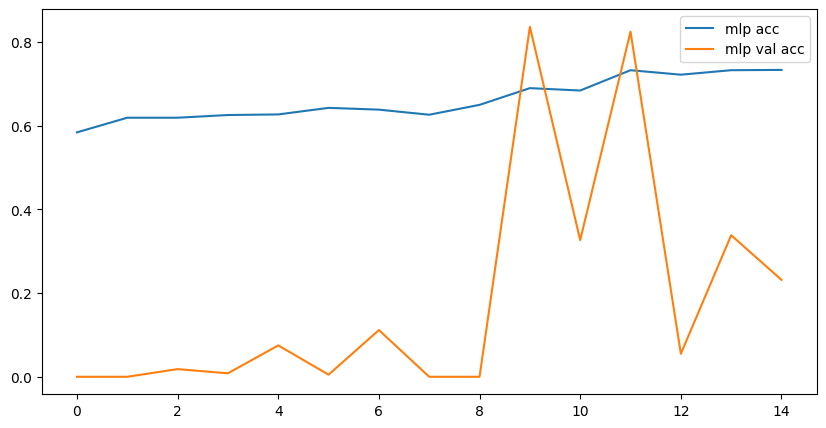

In [22]:
# 4. 시각화
plt.figure(figsize = (10, 5))
plt.plot(mlp_his.history['accuracy'], label = 'mlp acc')
plt.plot(mlp_his.history['val_accuracy'], label = 'mlp val acc')
plt.legend()
plt.show()
# 모델이 학습을 제대로 수행하지 못함! (과소적합)
# MLP 특성상 픽셀의 위치 값에 의존하여 학습하다보니 학습의 성능이 떨어질 수 있다

### CNN(Convolutional Neural Network, 합성곱 신경망)
1. 모델설계
  - 뼈대 생성
  - 특성추출부(Conv, Pool)
  - 분류부(MLP)
2. 학습 방법 설정
3. 학습
4. 예측 및 평가

In [23]:
# 라이브러리 로딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

# Conv2D : 특징을 잡아내는 역할을 하는 모듈 --> CNN
# MaxPooling2D : 중요한 정보만 걸러내는 역할을 하는 모듈 --> Pooling 역할
# Pooling -> 지역별로 중요한 특성의 값을 추출해내는 방식으로, 출력층의 이미지 크기가 작아지게 만듦

In [24]:
# 1. 설계
cnn_model = Sequential()
cnn_model.add(InputLayer(shape = (224, 224, 3)))

# 특성추출부
cnn_model.add(
    Conv2D(
        filters = 32,           # 커널의 개수
        kernel_size = (3, 3),   # 커널의 사이즈(커널 안의 가중치)
        activation = 'relu',
        strides = (2, 2),    # 커널의 보폭(양 옆, 위 아래로 2픽셀씩 건너뛰며 커널 이동시킴)
        padding = "same"))  # 패딩 : 입출력 이미지의 크기를 동일하게 하기 위해서 가장자리에 숫자(보통은 0)을 채워넣는 기능
                            # same : 이미지 자체가 작거나, 가장자리 정보가 중요할 때
                            # valid : 이미지 자체가 클 때(특징들이 많을 때)

cnn_model.add(MaxPooling2D(
    pool_size = (2, 2)))    # 풀링 윈두우 설정(풀링 사이즈는 보통 2 * 2 or 3 * 3을 많이 사용)

cnn_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', strides = (2, 2), padding = "same"))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', strides = (2, 2), padding = "same"))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

# MLP 분류부
cnn_model.add(Flatten())
# 은닉층
cnn_model.add(Dense(units = 256, activation = 'relu'))
cnn_model.add(Dense(units = 128, activation = 'relu'))
cnn_model.add(Dense(units = 64, activation = 'relu'))
# 출력층
cnn_model.add(Dense(units = 1, activation = 'sigmoid'))

In [25]:
# 2. 학습 방법 설정
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
# 3. 학습
cnn_his = cnn_model.fit(X_train, y_train,
                        epochs = 20,
                        validation_split= 0.3,
                        batch_size = 64   # 학습에 반영할 배치의 크기
                        # 배치의 크기가 클수록 필요한 연산 자원이 늘어나는 대신 빨리 끝남
                        )

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.5402 - loss: 10.5338 - val_accuracy: 0.2317 - val_loss: 0.9653
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6924 - loss: 0.6276 - val_accuracy: 0.0033 - val_loss: 1.7402
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7093 - loss: 0.6095 - val_accuracy: 0.0017 - val_loss: 1.5574
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7328 - loss: 0.5470 - val_accuracy: 0.0583 - val_loss: 1.3100
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7622 - loss: 0.4881 - val_accuracy: 0.0383 - val_loss: 1.8163
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7613 - loss: 0.4951 - val_accuracy: 0.1517 - val_loss: 1.6895
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7858 - loss: 0.4567 - val_accuracy: 0.2017 - val_loss: 1.4313
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8426 - loss: 0.3744 - val_accuracy: 0.3950 

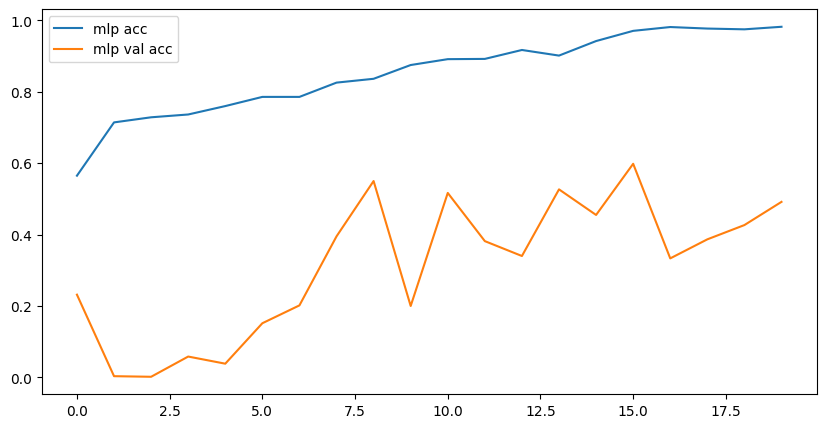

In [27]:
# 4. 시각화
plt.figure(figsize = (10, 5))
plt.plot(cnn_his.history['accuracy'], label = 'mlp acc')
plt.plot(cnn_his.history['val_accuracy'], label = 'mlp val acc')
plt.legend()
plt.show()

# 학습지에 대한 정확도가 너무 높다! -> 과대적합이 의심된다
# MLP에 비해서는 좀 더 일반화에 도달하고자 하는 추세가 보인다.

### 딥러닝의 성능을 끌어올려보자
- 이미지 데이터 증강
- 과대적합의 원인 찾기
--> 데이터셋이 늘어난 것처럼 증강을 통해 데이터 부족 현상(과적합)을 완화시킬 수 있다.

In [28]:
# 🔊 주의사항 🔊 : 데이터 증강은 Train set에 대해서만 적용
# test set에서의 데이터 증강은 신뢰할 수 없는 정보가 될 가능성이 있기 때문

In [29]:
# 이미지 라벨링, 픽셀값 변경, 증강 등에 사용되는 라이브러리
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:
# 증강할 데이터(원본) 경로 할당
train_dir = './data/cats_and_dogs_filtered/train'
test_dir = './data/cats_and_dogs_filtered/test'

| 옵션               | 설명                                                       |
|--------------------|------------------------------------------------------------|
| `rescale`          | 입력 이미지의 픽셀 값 재조정(ex.rescale=1.255 -> 모든 픽셀값들에 대해 0~1 사이로 정규화)|
| `rotation_range`   | 이미지의 회전 범위를 설정(ex.rotation_range -> -20~20도 사이에서 무작위로 회전)|
| `width_shift_range`| 이미지의 수평 이동 범위를 설정(ex.0.1은 전체 너비의 10%만큼 좌우로 무작위로 이동) |
| `height_shift_range`| 이미지의 수직 이동 범위를 설정(ex.0.1은 전체 너비의 10%만큼 위아래로 무작위로 이동)|
| `shear_range`      | 시계 반대 방향으로 지정된 각도만큼 변형       |
| `zoom_range`       | 이미지의 확대 및 축소 범위를 설정(ex.0.1 -> 0.9배~1.1배 사이에서 무작위로 확대하거나 축소) |
| `horizontal_flip`  | 이미지를 수평 방향으로 뒤집을지 여부를 설정       |
| `fill_mode`        | 이미지를 변형할 때 생기는 빈 공간을 채우는 방식을 설정(ex.nearest -> 가장 가까운 픽셀값을 사용하여 빈공간 채우기) |

In [31]:
# 증강기 생성
train_gen = ImageDataGenerator(
    rescale = 1./255,       # 이미지의 픽셀값을 0 ~ 1로 정규화
    zoom_range = 0.2,       # 0.8 ~ 1.2배 사이로 확대 및 축소
    horizontal_flip = True  # 수평 방향으로(양 옆으로) 뒤집기
    )
test_gen = ImageDataGenerator(rescale = 1./255)    # 정규화만 수행해야하고, 이미지 증식은 하면 안됨!

In [32]:
# 지정된 디렉토리에서 이미지 불러오고, 실시간으로 배치 데이터 생성
train_generator = train_gen.flow_from_directory(
    train_dir,                 # 원본 이미지 경로
    target_size = (224, 224),  # 이미지 크기 고정(가로, 세로)
    batch_size = 32,           # 한번에 학습시킬 이미지 개수
    class_mode = 'binary')     # binary = 이진분류

test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size = (224, 224),  # 이미지 크기 고정(가로, 세로)
    batch_size = 32,           # 한번에 학습시킬 이미지 개수
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [33]:
train_generator.class_indices   # 라벨 확인

{'cats': 0, 'dogs': 1}

### Dropout
- 신경망의 노드들을 지정한 비율로 비활성화
- 학습하는 동안에만 적용

In [34]:
# Dropout 라이브러리 불러오기
from tensorflow.keras.layers import Dropout

In [35]:
# 1. 설계
cnn_model = Sequential()
cnn_model.add(InputLayer(shape = (224, 224, 3)))

# 특성추출부
cnn_model.add(
    Conv2D(
        filters = 32,           # 커널의 개수
        kernel_size = (3, 3),   # 커널의 사이즈(커널 안의 가중치)
        activation = 'relu',
        strides = (2, 2),    # 커널의 보폭(양 옆, 위 아래로 2픽셀씩 건너뛰며 커널 이동시킴)
        padding = "same"))  # 패딩 : 입출력 이미지의 크기를 동일하게 하기 위해서 가장자리에 숫자(보통은 0)을 채워넣는 기능
                            # same : 이미지 자체가 작거나, 가장자리 정보가 중요할 때
                            # valid : 이미지 자체가 클 때(특징들이 많을 때)

cnn_model.add(MaxPooling2D(
    pool_size = (2, 2)))    # 풀링 윈두우 설정(풀링 사이즈는 보통 2 * 2 or 3 * 3을 많이 사용)

cnn_model.add(Dropout(0.3))   # 학습 시 30%의 노드를 랜덤하게 비활성화 시킨다(0으로 만듦)

cnn_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', strides = (2, 2), padding = "same"))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', strides = (2, 2), padding = "same"))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.3))

# MLP 분류부
cnn_model.add(Flatten())
# 은닉층
cnn_model.add(Dense(units = 256, activation = 'relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(units = 128, activation = 'relu'))
cnn_model.add(Dense(units = 64, activation = 'relu'))
# 출력층
cnn_model.add(Dense(units = 1, activation = 'sigmoid'))

In [36]:
# 2. 학습 방법 설정
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [35]:
# 3. 학습
cnn_his = cnn_model.fit(train_generator,
                        validation_data = test_generator,
                        epochs = 20,
                        )

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5129 - loss: 0.6925

KeyboardInterrupt: 

### 1. Transfer Learning
- **다른 데이터셋으로 이미 학습된 모델**을 유사한 다른 데이터를 인식하는데 사용하는 기법
- 특성추출방식
  - CNN 층에서 특성추출부만 가져와서 사용하는 방식
  - 특성추출부 부분만 사용하는 이유는 MLP의 경우 우리가 해결 하고자 하는 문제에 맞게 새로 설정해줘야 하기 때문
- Fine Tunning(미세조정방식)
  - '사전 학습된 모델의 가중치'를 목적에 맞게 전체 또는 일부를 재학습시키는 방식
  - 사전 학습된 가중치가 많이 손실될 수 있음

In [37]:
from tensorflow.keras.applications import VGG16 # 사전학습 모델

In [38]:
vgg16 = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = (224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# 1. 설계
transfer_model = Sequential()

# MLP 분류부
transfer_model.add(vgg16)

transfer_model.add(Flatten())

# 은닉층
transfer_model.add(Dense(units = 256, activation = 'relu'))
transfer_model.add(Dense(units = 128, activation = 'relu'))
transfer_model.add(Dense(units = 64, activation = 'relu'))

# 출력층
transfer_model.add(Dense(units = 1, activation = 'sigmoid'))

transfer_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [42]:
# 학습
transfer_model_history = transfer_model.fit(train_generator,
                                            validation_data = test_generator,
                                            epochs = 20)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1113s 17s/step - accuracy: 0.5035 - loss: 1.2067 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 769ms/step - accuracy: 0.5153 - loss: 0.7706 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 688ms/step - accuracy: 0.5093 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 686ms/step - accuracy: 0.5096 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 702ms/step - accuracy: 0.4903 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 683ms/step - accuracy: 0.5079 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 692ms/step - accuracy: 0.5053 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 806ms/step - accuracy: 0.5061 - loss: 0.6931 - val_accu

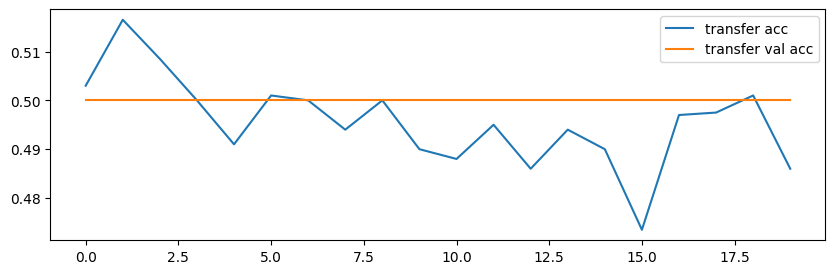

In [43]:
plt.figure(figsize = (10, 3))
plt.plot(transfer_model_history.history['accuracy'], label = 'transfer acc')
plt.plot(transfer_model_history.history['val_accuracy'], label = 'transfer val acc')
plt.legend()
plt.show()

In [44]:
for layer in transfer_model.layers[0].layers:
  if layer.name == 'block5_conv3':
    layer.trainable = True
  else:
    layer.trainable = False

In [45]:
from keras.optimizers import Adam

In [48]:
transfer_model.compile(loss = 'binary_crossentropy',
                       optimizer = Adam(learning_rate = 0.00001),
                       metrics = ['accuracy'])

In [49]:
transfer_model_history2 = transfer_model.fit(train_generator,
                                              validation_data = test_generator,
                                              epochs = 20)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 648ms/step - accuracy: 0.5107 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 593ms/step - accuracy: 0.4899 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 614ms/step - accuracy: 0.4960 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 600ms/step - accuracy: 0.5002 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 617ms/step - accuracy: 0.4993 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 613ms/step - accuracy: 0.4925 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 611ms/step - accuracy: 0.4905 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 597ms/step - accuracy: 0.5125 - loss: 0.6931 - val_accu

In [ ]:
plt.figure(figsize = (10, 3))
plt.plot(transfer_model_history2.history['accuracy'], label = 'finetuning acc')
plt.plot(transfer_model_history2.history['val_accuracy'], label = 'finetuning val acc')
plt.legend()
plt.show()